In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
from astropy.io import fits
from astropy.table import Table, vstack
from pathlib import Path
import os
import math
import glob
import warnings
warnings.filterwarnings('ignore')

## RMS catalogue

In [2]:
tablename1 = 'C:\\Users\\hepbu\\Documents\\2021\\Honours Project\\SAMI DATA\\jvds_kin_mtype_cat_v040421.fits'
cat22 = Table.read(tablename1, hdu = 1)
rms = cat22.field('RMS_VOTES')

## Kinematics catalogue

In [3]:
tablename = 'C:\\Users\\hepbu\\Documents\\2021\\Honours Project\\SAMI DATA\\jvds_stelkin_cat_v012_mge_seecorr_kh20_v150121_private-Copy1.fits'
cat = Table.read(tablename, hdu=1)
cat['RMS_VOTES'] = rms

In [37]:
cat[0:5]

CATID,CATID_EXT,SAMI_FILENAME,OBS_DATE,RA,DEC,LMSTAR,Z_SPEC,Z_TONRY,GMINUSI,MU_AT_RE,GAL_FLAG,HWHM_PSF,RE,RE_CIRC_KPC,ELLIP,N_SERSIC,MTYPE,KIN_MTYPE,ENV_DIST_TO_5NN,ENV_SURFDENS,E_ENV_SURFDENS,SAMI_ISO,SAMI_CENTRAL,SAMI_SAT,HALOMASS,HALOMASS_UNIQUE,GROUP_ID,HALOMASS_WEIGHT,PA_PHOT,PA_STELKIN,E_PA_STELKIN,PA_GASKIN,E_PA_GASKIN,RMAX_VSIGMA,SIGMA_RE,E_SIGMA_RE,VRMS_RE,E_VRMS_RE,APER_CORR_FLAG,RMAX_APER_CORR,LAMBDAR_RE,E_LAMBDAR_RE,LAMBDAR_MAX,E_LAMBDAR_MAX,LAMBDAR_RE_EO,E_LAMBDAR_RE_EO,VSIGMA_RE,E_VSIGMA_RE,VSIGMA_MAX,EVSIGMA_MAX,VSIGMA_RE_EO,E_VSIGMA_RE_EO,MEAN_K51_RE,E_MEAN_K51_RE,FR_EE11,SR_EE11,FR_MC16,SR_MC16,FR_JVDS20,SR_JVDS20,PFR_JVDS20,PSR_JVDS20,INTRINSIC_ELLIP,INCLINATION,LR_SEEING_CORRECTION,VS_SEEING_CORRECTION,HIGH_ORDER_CLASS,RMS_VOTES
int64,int64,bytes69,bytes21,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float64,float64,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32
6821,6821,6821_7_Y18SAR4_P001_12T126_2018_05_07-2018_05_16.fits.gz,2018_05_07-2018_05_16,174.15315,0.815855,7.42,0.00375,0.00443,-0.01,23.51,3.0,1.4091473,6.849334,0.41975373,0.37479904,7.2232,3.0,6.0,nan,nan,nan,1.0,nan,nan,nan,nan,nan,1.0,134.77594,nan,nan,344.0,0.16666667,1.6666667,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
6837,6837,6837_7_Y18SAR4_P001_12T126_2018_05_07-2018_05_16.fits.gz,2018_05_07-2018_05_16,174.30278,0.7899846,9.0,0.0742,0.0742,9.999,9.999,8.0,1.4091473,nan,nan,nan,nan,3.0,6.0,1.384,nan,nan,nan,1.0,nan,257753714284.17548,257753714284.17548,203007.0,1.0,nan,nan,nan,289.5,0.16666667,7.5,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
7139,7139,7139_7_Y18SAR3_P002_12T122_2018_05_07-2018_05_16.fits.gz,2018_05_07-2018_05_16,175.82831,0.747881,10.63,0.07567,0.07697,1.36,20.03,0.0,0.7494104,1.0257354,1.3232017,0.1923237,3.337,1.0,6.0,1.0,0.27,0.0289,nan,1.0,nan,55228194660.07442,55228194660.07442,203032.0,1.0,-90.39273,267.5,1.5,181.0,0.16666667,3.6000001,235.61281,3.229881,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
7206,7206,7206_7_Y18SAR3_P002_12T122_2018_05_07-2018_05_16.fits.gz,2018_05_07-2018_05_16,176.1641,0.749569,10.48,0.09339,0.09471,0.91,21.78,0.0,0.7494104,3.1248665,4.540183,0.29915828,1.4784,2.0,6.0,1.0,1.138,0.4627,nan,1.0,nan,3300007829417.872,3300007829417.872,203039.0,1.0,106.22249,277.0,1.4166666,279.5,0.25,5.2,104.364845,1.8333597,103.75486,30.076302,0.0,1.0,0.65009856,0.014969519,nan,nan,0.7064621,0.016267376,0.86284924,0.023065692,nan,nan,1.0090297,0.026973391,0.034964137,0.008393184,1.0,nan,1.0,nan,1.0,nan,1.0,nan,0.8531062,46.107323,1.2044398,1.2768883,nan,nan
7289,7289,7289_7_Y18SAR3_P002_12T122_2018_05_07-2018_05_16.fits.gz,2018_05_07-2018_05_16,176.77502,0.635689,11.12,0.08682,0.08813,1.32,22.17,0.0,0.7494104,3.3211834,4.7925606,0.21212418,4.4338,0.5,0.0,1.0,0.376,0.0336,nan,1.0,nan,2315613883694.7866,2315613883694.7866,203048.0,1.0,102.06984,84.5,12.75,100.0,0.33333334,6.2666664,212.49521,1.5672057,211.05315,60.873405,0.0,1.0,0.070310414,0.0069313175,nan,nan,0.070310414,0.0069313175,0.075100034,0.006164173,nan,nan,0.075100034,0.006164173,0.23975329,0.072991356,nan,1.0,nan,1.0,nan,1.0,nan,1.0,nan,nan,1.2563438,1.2205775,1.0,0.5345225


In [4]:
# make an array for each important dataset
CATID = cat.field('CATID')
KIN_MTYPE = cat.field('KIN_MTYPE')
FILENAME = cat.field('SAMI_FILENAME')
CATID_EXT = cat.field('CATID_EXT')
LMSTAR = cat.field('LMSTAR')
RE_CIRC_KPC = cat.field('RE_CIRC_KPC')
SIGMA_RE = cat.field('SIGMA_RE')
GAL_FLAG = cat.field('GAL_FLAG')
# RMS = cat.field('RMS_VOTES')

In [5]:
#TESTING SAMPLE

cat['RMS_VOTES'] = rms
RMS = cat.field('RMS_VOTES')
cat = cat[np.where(RMS < 1.5)]
KIN_MTYPE = cat.field('KIN_MTYPE')
cat = cat[np.where(KIN_MTYPE < 4)]

# LMSTAR = cat.field('LMSTAR')
# cat = cat[np.where(LMSTAR > 10)]

In [6]:
np.shape(cat)

(490,)

In [6]:
#FACE ON SPIRAL

cat['RMS_VOTES'] = rms
RMS = cat.field('RMS_VOTES')
# cat = cat[np.where(RMS > 1.5)]
KIN_MTYPE = cat.field('KIN_MTYPE')
# cat = cat[np.where(KIN_MTYPE < 6)]
cat = cat[np.where(KIN_MTYPE > 3.5)]
KIN_MTYPE = cat.field('KIN_MTYPE')
cat = cat[np.where(KIN_MTYPE < 6)]


In [39]:
#RMS > 1.5

cat['RMS_VOTES'] = rms
RMS = cat.field('RMS_VOTES')
cat = cat[np.where(RMS > 1.49)]
KIN_MTYPE = cat.field('KIN_MTYPE')
cat = cat[np.where(KIN_MTYPE < 4)]

In [25]:
#UNCLASSIFIED

KIN_MTYPE = cat.field('KIN_MTYPE')
cat = cat[np.where(KIN_MTYPE == 6)]

In [41]:
np.size(cat2)

48

In [21]:
np.size(cat1)

60

In [27]:
np.size(cat3)

2832

In [7]:
cat1 = cat

In [40]:
cat2 = cat

In [26]:
cat3 = cat

In [55]:
new = vstack([cat1, cat2, cat3])

In [57]:
cat6 = new

In [58]:
CATID = cat6.field('CATID')
KIN_MTYPE = cat6.field('KIN_MTYPE')
FILENAME = cat6.field('SAMI_FILENAME')
CATID_EXT = cat6.field('CATID_EXT')
LMSTAR = cat6.field('LMSTAR')
RE_CIRC_KPC = cat6.field('RE_CIRC_KPC')
SIGMA_RE = cat6.field('SIGMA_RE')

In [56]:
np.size(new)

2940

In [59]:
np.size(FILENAME)

2940

In [60]:
MSOLAR = 1.98892e30
G = 6.67300e-11
kpctom = 3.08568025e19

def SIGMA_STAR_CALC(LMSTAR_VAL, RE_CIRC_VAL):
    return math.sqrt(((10**LMSTAR_VAL)*MSOLAR*G)/(RE_CIRC_VAL*kpctom*5))/(1e3)

SIGMA_STAR = []
for i in range(LMSTAR.size):
    SIGMA_STAR += [SIGMA_STAR_CALC(LMSTAR[i],RE_CIRC_KPC[i])]
    
SIGMA_STAR = np.array(SIGMA_STAR)

NANS_SIGMA_RE = np.argwhere(np.isnan(SIGMA_RE))
SIGMA_STAR_1 = SIGMA_STAR[NANS_SIGMA_RE]
SIGMA_RE[NANS_SIGMA_RE] = SIGMA_STAR_1

In [61]:
np.size(SIGMA_RE)

2940

In [62]:
CATID_TO_RUN = CATID_EXT

In [ ]:
sig_max = np.nanmax(SIGMA_RE)
training_data_1 = []
ratios = []
minmax = np.zeros((4, np.size(CATID_TO_RUN)))
for i in range(0,np.size(CATID_TO_RUN)):
    a  = np.where(CATID_TO_RUN[i] == CATID_EXT)
    idx = a[0][0]   
#     print('Galaxy', i)
    catid_use = str(CATID_TO_RUN[i])
    if catid_use == '209613':
        minmax[0,i] = np.NaN
        minmax[1,i] = np.NaN
        minmax[2,i] = np.NaN
        minmax[3,i] = np.NaN
        continue
        
    sami_file_name = FILENAME[idx]  
    s = str(sami_file_name)
    s = s.strip()
    num = s.find('_')
    l = len(s)
    s = 'C:\\Users\\hepbu\\Documents\\2021\\Honours Project\\SAMI DATA\\two_moments\\' + \
    s[:num] + '_blue_red' + s[num:l-8] + '_kinematicsM2'+ s[l-8:-3]
    filename = s
    
    data = fits.open(filename)
    # open the velocity & error & snr
    
    vel = data['VEL'].data
    vel_err = data['VEL_ERR'].data
    sig = data['SIG'].data
    sig_err = data['SIG_ERR'].data
    qc = data['QC'].data
    snr = qc[:,:,3]
    
# find where the conditions are met and filter out error values

    centre = vel[22:28,22:28]
#     centre2 = np.ones((np.shape(centre)))
    median = np.nanmedian(centre)
    vel = vel - median
    
#     vel_97 = np.nanpercentile(vel, 97)
#     vel_3 = np.nanpercentile(vel, 3)
#     sig_97 = np.nanpercentile(sig, 97)
    
    vel_3sigmax = np.nanmean(vel) + 3*np.nanstd(vel)
    vel_3sigmin = np.nanmean(vel) - 3*np.nanstd(vel)
    sig_3sigmax = np.nanmean(sig) + 3*np.nanstd(sig)
    
    vel = np.where((vel_err <= 30) & (snr >= 3) & (sig_err < sig*0.1 +25) & \
                 (vel < vel_3sigmax) & (vel > vel_3sigmin) & (sig < sig_3sigmax), vel, np.NaN)  
    

    sig = np.where((vel_err <= 30) & (snr >= 3) & (sig_err < sig*0.1 +25) & \
                 (vel < vel_3sigmax) & (vel > vel_3sigmin) & (sig < sig_3sigmax), sig, np.NaN) 
    
#     vmin = np.nanmin(vel)
#     vmax = np.nanmax(vel)
#     smin = np.nanmin(sig)
#     smax = np.nanmax(sig)
    
    
#     minmax[0,i] = vmin
#     minmax[1,i] = vmax
#     minmax[2,i] = smin
#     minmax[3,i] = smax


# Normalize values between 0 and 1 

    sig95 = np.nanpercentile(sig, 95)
    sig90 = np.nanpercentile(sig, 90)
    sig_re  = SIGMA_RE[i]
    
    if math.isnan(sig_re):
        sig_use = sig90
        
    else:
        sig_use = sig_re
    
    sig_use = abs(sig_use)
    
#     vel = np.where(vel > sig_use, sig_use, vel)
#     print('GALAXY: ', catid_use)
#     print('SIGMA_RE: ',sig_re)
#     print('95th percentile: ', sig95)
#     print('90th percentile: ', sig90)
    
    sig = (sig - np.nanmin(sig))/(np.nanmax(sig) - np.nanmin(sig))
    sig = np.nan_to_num(sig, 0)    
#     sig = sig*sig_ratio

    vel99 = abs(np.nanmax(vel))
    ratio = vel99/sig_use
  
    if ratio > 1:
        ratio = 1
        
#     print('ratio: ', ratio)
#     print('ratio2: ',ratio2)
        
    vel = (vel - np.nanmin(vel))/(np.nanmax(vel) - np.nanmin(vel))
    vel = np.nan_to_num(vel, nan = 0.5) 
    
    vel = (2*vel)-1 
    
    vel = vel*ratio
    
    vel = (vel+1)/2
    
    class_num = KIN_MTYPE[idx]
    catid_ext = CATID_EXT[idx]
#     ratios.append(ratio)
#     training_data_1.append([vel])
    training_data_1.append([vel, sig, class_num, catid_ext])



In [59]:
np.shape(vmin)

(2940,)

In [ ]:
np.shape(training_data_1)

In [216]:
X = []
X1 = []
Y = []
Z = []


for maps, sigmaps, labels, catids, in training_data_1:
    X.append(maps)
    X1.append(sigmaps)
    Y.append(labels)
    Z.append(catids)

X = np.array(X).reshape(-1, 50,50, 1)
X1 = np.array(X1).reshape(-1, 50,50, 1)
Y = np.array(Y)
Z = np.array(Z)

In [218]:
np.shape(Z)

(2939,)

In [ ]:
catids = 

In [53]:
# vmin = minmax[0, :]
# vmax = minmax[1, :]
# smin = minmax[2, :]
# smax = minmax[3, :]

In [219]:
# X_vals_classified = np.save('C:\\Users\\hepbu\\Documents\\2021\\Honours Project\\SAMI DATA\\TRAINING_DATA\\vel_notrain_280921', X)
# X1_vals_classified = np.save('C:\\Users\\hepbu\\Documents\\2021\\Honours Project\\SAMI DATA\\TRAINING_DATA\\sig_notrain_280921', X1)
# Y_vals_classified = np.save('C:\\Users\\hepbu\\Documents\\2021\\Honours Project\\SAMI DATA\\TRAINING_DATA\\sig_min_notrain_210921', smin)
Z_vals_classified = np.save('C:\\Users\\hepbu\\Documents\\2021\\Honours Project\\SAMI DATA\\TRAINING_DATA\\catid_ext_notrain_280921', Z)


In [128]:
np.where(Z == 70022)

(array([37], dtype=int64),)

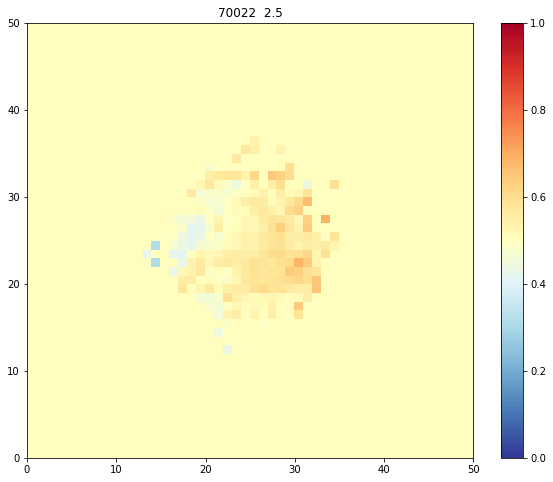

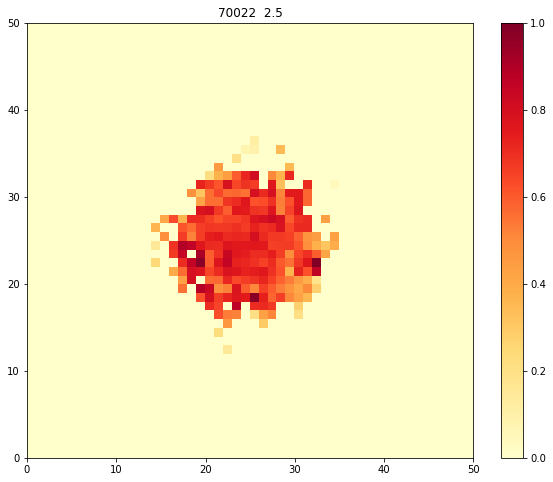

In [129]:
n = 37
a = training_data_1[n][0]
b = training_data_1[n][1]
c = training_data_1[n][2]
d = training_data_1[n][3]

plt.figure(figsize=(10, 8))
plt.pcolor(a, cmap = 'RdYlBu_r', vmin = 0, vmax = 1)
# plt.imshow(centre2)
plt.colorbar()
plt.title(str(d) + '  '  + str(c))
plt.show()

plt.figure(figsize=(10, 8))
# plt.pcolor(a, cmap = 'RdYlBu_r', vmin = 0, vmax = 1)
plt.pcolor(b, cmap = 'YlOrRd', vmin = 0, vmax = 1)
# plt.imshow(centre2)
plt.colorbar()
plt.title(str(d) + '  '  + str(c))
plt.show()

Text(0.5, 1.0, '272190')

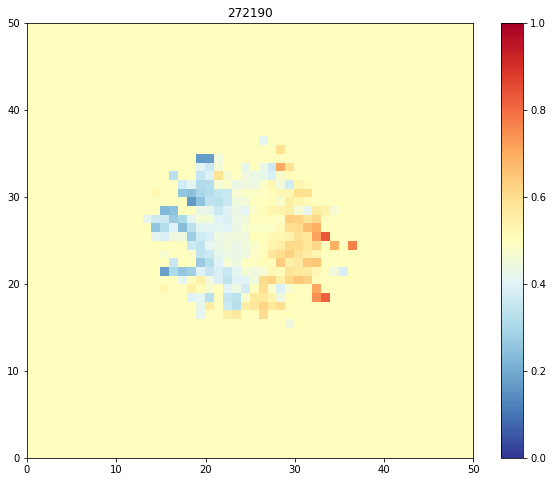

In [102]:
np.shape(training_data_1)

(490, 4)

## Voranoid Maps

In [41]:
# CATID_TO_RUN = CATID_EXT

# sig_max = np.nanmax(SIGMA_RE)
# training_data_1 = []

# for i in range(0,np.size(CATID_TO_RUN)):

#     catid_use = str(CATID_TO_RUN[i])
#     if catid_use == '209613':
#         continue
#     sami_file_name = FILENAME[i]  
#     s = str(sami_file_name)
#     s = s.strip()
#     num = s.find('_')
#     l = len(s)
#     s = 'C:\\Users\\hepbu\\Documents\\2021\\Honours Project\\SAMI DATA\\two_moments\\' + s[:num] + \
#     '_blue_red' + s[num:l-8] + '_kinematicsM2'+ s[l-8:-3]
#     filename = s
    
#     data = fits.open(filename)
#     # open the velocity & error & snr
    
#     vel = data['VEL'].data
    
#     vel_binned = data['VEL_BINNED_ADAPTIVE'].data
#     snr_binned = data['FORMAL_SNR_BINNED_ADAPTIVE'].data
#     vel_err_binned = data['VEL_ERR_BINNED_ADAPTIVE'].data
#     sig_binned = data['SIG_BINNED_ADAPTIVE'].data
#     sig_err_binned = data['SIG_ERR_BINNED_ADAPTIVE'].data
    
#     # find where the conditions are met and filter out bad values

#     centre = vel[23:30,23:30]
#     median = np.nanmedian(centre)
#     vel_binned = vel_binned - median
    
#     vel_3sigmax = np.nanmean(vel_binned) + 3*np.nanstd(vel_binned)
#     vel_3sigmin = np.nanmean(vel_binned) - 3*np.nanstd(vel_binned)
#     sig_3sigmax = np.nanmean(sig_binned) + 3*np.nanstd(sig_binned)
    
#     vel_binned = np.where((vel_err_binned <= 30) & (snr_binned >= 3) & (sig_binned > 35) & \
#                  (sig_err_binned < sig_binned*0.1 +25) & (vel_binned < vel_3sigmax) & (vel_binned > vel_3sigmin) \
#                  & (sig_binned < sig_3sigmax), vel_binned, np.NaN)
    
#     sig_binned = np.where((vel_err_binned <= 30) & (snr_binned >= 3) & (sig_binned > 35) & \
#                     (sig_err_binned < sig_binned*0.1 +25) & (vel_binned < vel_3sigmax) & (vel_binned > vel_3sigmin) \
#                      & (sig_binned < sig_3sigmax), sig_binned, np.NaN)
    
# #     vel_binned = np.multiply(vel_binned, a)
# #     sig_binned = np.multiply(sig_binned, a)

#     sig = sig_binned
#     vel = vel_binned
    
#     # Normalize values between 0 and 1

# #     sig_max_1 = np.nanmax(sig)
# #     sig_ratio = sig_max_1/sig_max
# #     if sig_ratio > 1:
# #         sig_ratio = 1    

#     sig = (sig - np.nanmin(sig))/(np.nanmax(sig) - np.nanmin(sig))
#     sig = np.nan_to_num(sig, 0)    
# #     sig = sig*sig_ratio

#     vel = (vel - np.nanmin(vel))/(np.nanmax(vel) - np.nanmin(vel))
#     vel = np.nan_to_num(vel, nan = 0.5) 
    
#     class_num = KIN_MTYPE[i]
#     galaxy_ID = catid_use
    
#     training_data_1.append([vel, sig, class_num, galaxy_ID])


In [42]:
np.shape(training_data_1)

(428, 4)

In [47]:
n = 10
a = training_data_1[n][0]
b = training_data_1[n][1]
c = training_data_1[n][2]
d = training_data_1[n][3]

In [125]:
# fig, axs = plt.subplots(1,2, figsize = (14, 6))
# fig.suptitle('Label: '+ str(c) + ' ---- ' + "CATID: " + str(d))
# a1 = axs[0].pcolor(a, cmap = 'RdYlBu_r', vmin = 0, vmax = 1)
# fig.colorbar(a1, ax = axs[0],  fraction=0.046, pad=0.04)

# a2 = axs[1].pcolor(b, cmap = 'YlOrRd')
# fig.colorbar(a2, ax = axs[1],  fraction=0.046, pad=0.04)

In [131]:
training_data_3 = training_data_1

In [132]:
#AUGMENTATION FOR NORS
import random
size = np.shape(training_data_3)[0]

for i in range(0, size):
    vmap = training_data_3[i][0]
    sigmap = training_data_3[i][1]
    label = training_data_3[i][2]
    catid = training_data_3[i][3]
    
    if label < 1.5:
        for a in range(1,4):
            vmap_new = np.rot90(vmap, k = a, axes = (0,1))
            sigmap_new = np.rot90(sigmap, k = a, axes = (0,1))
            training_data_3.append([vmap_new,sigmap_new, label, catid])
    else:
        r = random.randint(1,3)
        vmap_new = np.rot90(vmap, k = r, axes = (0,1))
        sigmap_new = np.rot90(sigmap, k = r, axes = (0,1))
        training_data_3.append([vmap_new, sigmap_new, label, catid])

In [133]:
print(np.shape(training_data_3))

(1242, 4)


In [ ]:
# AUGMENTATION FOR FEATURES

size = np.shape(training_data_1)[0]

training_data_test = training_data_1
for i in range(0, size+1):
    label = training_data_1[i][1]
    if label == 1.0:
        vmap = training_data_1[0][0]
        for a in range(1,4):
            vmap = np.rot90(vmap, k = a, axes = (0,1))
            training_data_test.append([vmap, label, galaxy_ID])
            
    if label == 2.0:
        vmap = training_data_1[0][0]
        for a in range(1,4):
            vmap = np.rot90(vmap, k = a, axes = (0,1))
            training_data_test.append([vmap, label, galaxy_ID])

In [134]:
X = []
X1 = []
Y = []
Z = []


for maps, sigmaps, labels, catids, in training_data_3:
    X.append(maps)
    X1.append(sigmaps)
    Y.append(labels)
    Z.append(catids)

X = np.array(X).reshape(-1, 50,50, 1)
X1 = np.array(X1).reshape(-1, 50,50, 1)
Y = np.array(Y)
Z = np.array(Z)

In [126]:
np.where(Z == 54270)

(array([29], dtype=int64),)

In [49]:
Y = np.where(Y > 1, 1, 0)

(array([131.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0., 359.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <BarContainer object of 10 artists>)

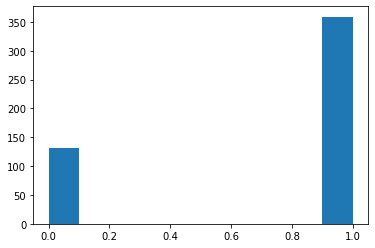

In [50]:
plt.hist(Y)

In [135]:
X_vals_classified = np.save('C:\\Users\\hepbu\\Documents\\2021\\Honours Project\\SAMI DATA\\TRAINING_DATA\\veltrain_sigscale_2809', X)
# X1_vals_classified = np.save('C:\\Users\\hepbu\\Documents\\2021\\Honours Project\\SAMI DATA\\TRAINING_DATA\\sigtrain_2809', X1)
# Y_vals_classified = np.save('C:\\Users\\hepbu\\Documents\\2021\\Honours Project\\SAMI DATA\\TRAINING_DATA\\label_human_190921', Y)
# Z_vals_classified = np.save('C:\\Users\\hepbu\\Documents\\2021\\Honours Project\\SAMI DATA\\TRAINING_DATA\\catid_ext_human_190921', Z)


In [ ]:
X_vals_classified = np.save('C:\\Users\\hepbu\\Documents\\2021\\Honours Project\\SAMI DATA\\TRAINING_DATA\\voranoid_vel_140721', X)
X1_vals_classified = np.save('C:\\Users\\hepbu\\Documents\\2021\\Honours Project\\SAMI DATA\\TRAINING_DATA\\voranoid_sig_140721', X1)
Y_vals_classified = np.save('C:\\Users\\hepbu\\Documents\\2021\\Honours Project\\SAMI DATA\\TRAINING_DATA\\voranoid_label_140721', Y)
Z_vals_classified = np.save('C:\\Users\\hepbu\\Documents\\2021\\Honours Project\\SAMI DATA\\TRAINING_DATA\\catid_ext_140721', Z)

In [57]:
X_vals_classified = np.save('C:\\Users\\hepbu\\Documents\\2021\\Honours Project\\SAMI DATA\\TRAINING_DATA\\vel_sigscale_notrain2109', X)

In [31]:
np.shape(X)

(1242, 50, 50, 1)